# Data Transmission and Quantum Teleportation between two parties

In [2]:
import numpy as np
import qiskit
assert qiskit.__version__ == '1.4.1'
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram, plot_bloch_multivector, plot_state_city


### Creating the **shared** Bell state

In [3]:
def create_bell_state(qc:QuantumCircuit, a:int, b:int):
    qc.h(a)
    qc.cx(a, b)

# apply a bell measurement
def bell_measurement(qc:QuantumCircuit, a:int, b:int):
    qc.measure(a, 0)
    qc.measure(b, 1)

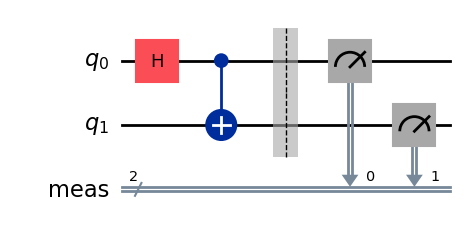

In [4]:
# create a quantum circuit on 2 qubits imposing a Bell state
qc = QuantumCircuit(2)

create_bell_state(qc, 0, 1)

qc.measure_all()

qc.draw(output='mpl')

Mesuring the bell state

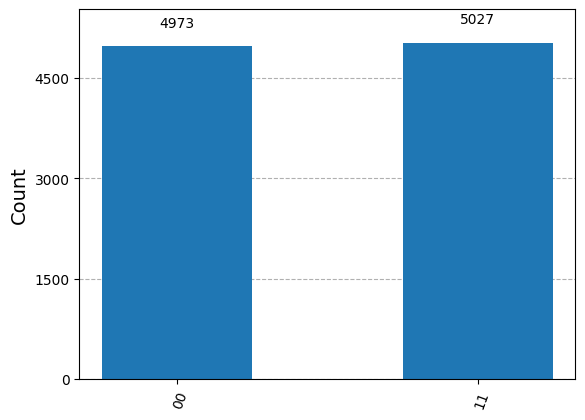

In [5]:
# check bell state status
sim = AerSimulator(method='statevector')
result = sim.run(qc, shots=10000).result()

plot_histogram(result.get_counts())

### Send 2 bit data through Bell State Entanglement

<div style="text-align: center;">
<img src="quatum_teleportation_1.png" alt="Centered Image" width=600>
</div>

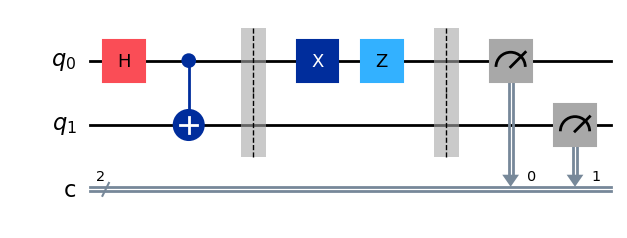

In [29]:
def two_bit_transmission(a, b):
    qc = QuantumCircuit(2, 2)
    
    create_bell_state(qc, 0, 1)

    qc.barrier()

    if(a == 1):
        qc.x(0)
    else:
        qc.id(0)

    if(b == 1):
        qc.z(0)
    else:
        qc.id(0)
    
    qc.barrier()

    bell_measurement(qc, 0, 1)
    # qc.measure_all()

    return qc

two_bit_transmission(1, 1).draw(output='mpl')

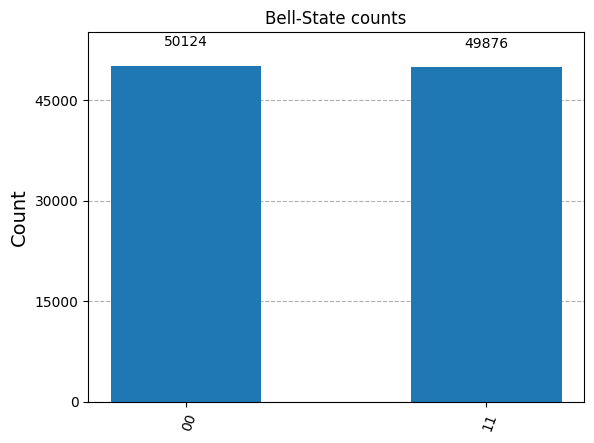

In [ ]:
qc = two_bit_transmission(0, 0)

sim = AerSimulator(method='statevector')
result = sim.run(qc, shots=100000).result()


plot_histogram(result.get_counts(), title='Bell-State counts')
# qc.draw(output='mpl')

### Comparing 2 bit data on bell measurements

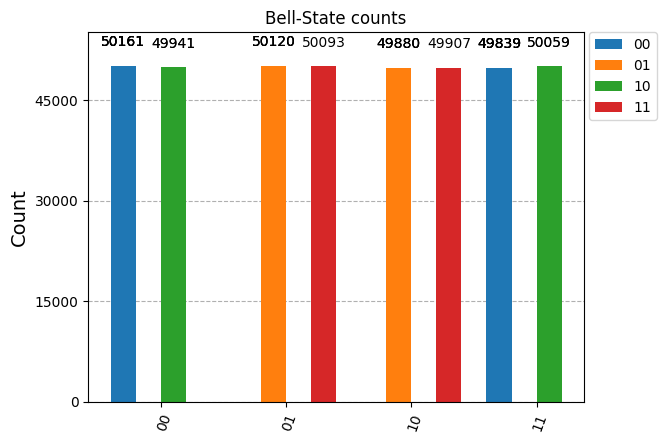

In [9]:
counts = []
labels = ['00', '01', '10', '11']

for i in range(4):
    qc = two_bit_transmission(i & 1, i >> 1)
    sim = AerSimulator(method='statevector')
    result = sim.run(qc, shots=100000).result()
    counts.append(result.get_counts())

plot_histogram(counts, title='Bell-State counts', legend=labels)

## Running on real backend

In [10]:
# Implementation on read backend
from qiskit_ibm_runtime import QiskitRuntimeService

# Get the backend
service = QiskitRuntimeService()

print("List of backends: ", service.backends(simulator=False, operational=True, min_num_qubits=5))
leas_busy = service.least_busy(operational=True, min_num_qubits=5)
print("Least busy backend: ", leas_busy)

List of backends:  [<IBMBackend('ibm_brisbane')>, <IBMBackend('ibm_kyiv')>, <IBMBackend('ibm_sherbrooke')>]
Least busy backend:  <IBMBackend('ibm_brisbane')>


In [30]:
qc_s = []
counts = []
labels = ['00', '10', '01', '11']

for i in range(4):
    qc_s.append(two_bit_transmission(i & 1, i >> 1))
    qc_s[i].draw(output='mpl', filename=f'bell_{i}.png')

In [21]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

# Generate a pass manager
pass_manager = generate_preset_pass_manager(
    optimization_level=3,
    backend=leas_busy
)

# Transpile the circuits
qc_s_trans = pass_manager.run(qc_s)

In [ ]:
from qiskit_ibm_runtime import Session, SamplerV2 as Sampler

if 0:
    with Session(backend=leas_busy) as session:
        sampler = Sampler(mode=session)
        job = sampler.run(qc_s_trans, shots=10000)
        print(f"Sampler job ID: {job.job_id()}")

### First Run

PrimitiveResult([SamplerPubResult(data=DataBin(c=BitArray(<shape=(), num_shots=10000, num_bits=2>)), metadata={'circuit_metadata': {}}), SamplerPubResult(data=DataBin(c=BitArray(<shape=(), num_shots=10000, num_bits=2>)), metadata={'circuit_metadata': {}}), SamplerPubResult(data=DataBin(c=BitArray(<shape=(), num_shots=10000, num_bits=2>)), metadata={'circuit_metadata': {}}), SamplerPubResult(data=DataBin(c=BitArray(<shape=(), num_shots=10000, num_bits=2>)), metadata={'circuit_metadata': {}})], metadata={'execution': {'execution_spans': ExecutionSpans([DoubleSliceSpan(<start='2025-03-19 01:29:40', stop='2025-03-19 01:29:51', size=40000>)])}, 'version': 2})


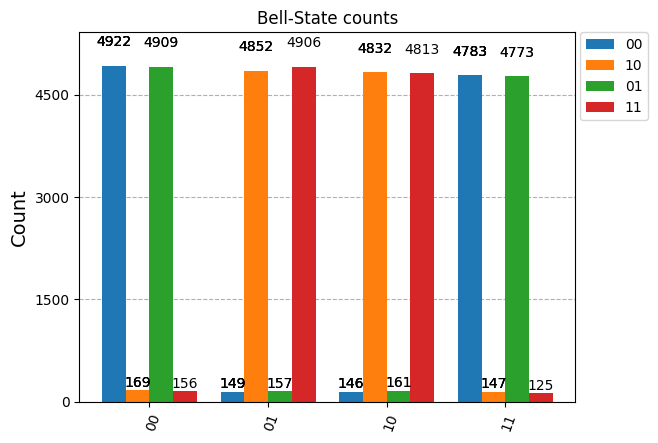

In [31]:
job_id = 'czd1w00tp60g008hh050'
result = service.job(job_id).result()
print(result)

results = [result[i].data.c.get_counts() for i in range(4)]

plot_histogram(results, title='Bell-State counts', legend=labels)

### Second RUn

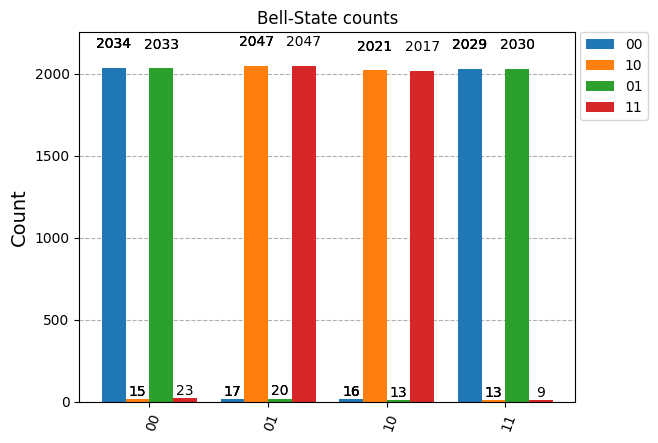

In [33]:
job_id = 'czd1qrqqadq0008cq48g'
result = service.job(job_id).result()
# print(result)
results = [result[i].data.c.get_counts() for i in range(4)]

plot_histogram(results, title='Bell-State counts', legend=labels)

The results are not as expected, the |00> state is not distinguishable from the |01> state (or |10>, |11>).

This is due to the measuring method, the final states calculated are:

* $\psi_{00} = \frac{|00> + |11>}{\sqrt{2}}$
* $\psi_{01} = \frac{|00> - |11>}{\sqrt{2}}$

* $\psi_{10} = \frac{|10> + |01>}{\sqrt{2}}$
* $\psi_{11} = \frac{|10> - |01>}{\sqrt{2}}$

The states $\psi_{10}$ differs from $\psi_{11}$ only by a phase, so the probabilities remain the same!!

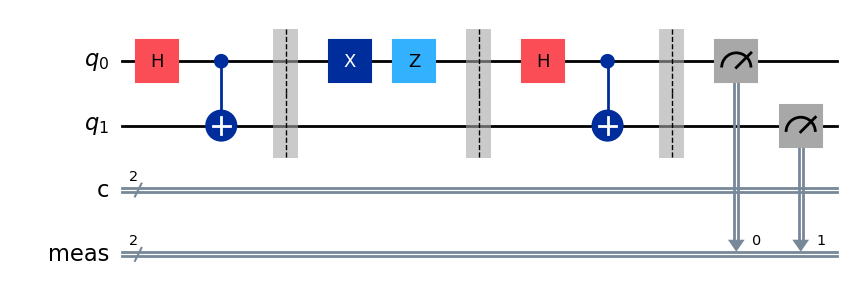

In [35]:
def two_bit_transmission_2(a, b):
    qc = QuantumCircuit(2, 2)
    
    create_bell_state(qc, 0, 1)

    qc.barrier()

    if(a == 1):
        qc.x(0)
    else:
        qc.id(0)

    if(b == 1):
        qc.z(0)
    else:
        qc.id(0)
    
    qc.barrier()

    qc.h(0)
    qc.cx(0, 1)

    qc.measure_all()

    # bell_measurement(qc, 0, 1)
    # qc.measure_all()

    return qc

two_bit_transmission_2(1, 1).draw(output='mpl')

## Quantum Teleportation Circuit

<div style="text-align: center;">
<img src="qt_2.png" alt="Centered Image" width=600>
</div>

In [15]:
from qiskit import QuantumRegister, ClassicalRegister
from qiskit.circuit.classical import expr

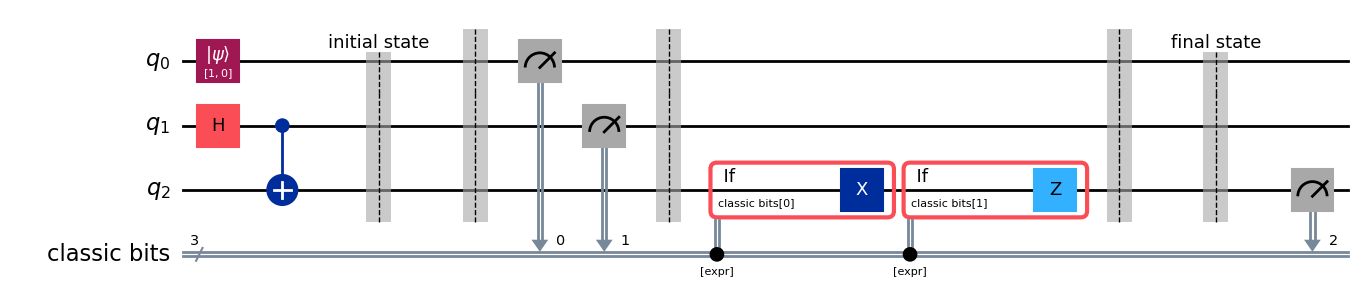

In [16]:
def quantum_teleportation(psi_init):
    quantum_register = QuantumRegister(3, 'q')
    classical_register = ClassicalRegister(3, 'classic bits')
    
    qc = QuantumCircuit(quantum_register, classical_register)

    # create a Bell state on qbits 1 and 2
    create_bell_state(qc, 1, 2)

    # create a qubit to be teleported
    qc.initialize(psi_init, 0)

    qc.save_statevector(label='initial state')

    qc.barrier()

    # apply bell measurement on qbits 0 and 1
    qc.measure(0, 0)
    qc.measure(1, 1)

    qc.barrier()

    # apply gates to the qubit to be teleported for encoding data
    a_bit = expr.lift(classical_register[0])
    with qc.if_test(a_bit):
        qc.x(2)

    b_bit = expr.lift(classical_register[1])
    with qc.if_test(b_bit):
        qc.z(2)
    

    qc.barrier()

    # save final teleportation state
    qc.save_statevector(label='final state')

    # measure the teleported qubit
    qc.measure(2, 2)

    return qc

quantum_teleportation([1, 0]).draw(output='mpl', fold=-1)

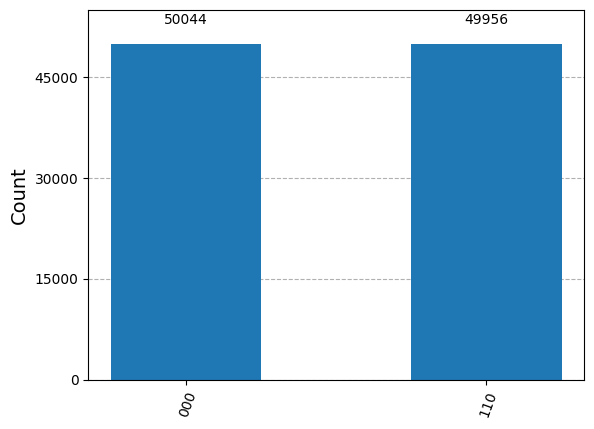

In [17]:
initial_state = [1, 0]

qc = quantum_teleportation(psi_init=initial_state)
sim = AerSimulator(method='statevector')
result = sim.run(qc, shots=100000).result()

# init_state = result.data()['initial state']
# fin_state = result.data()['final state']
# plot the histogram
# print(result)
plot_histogram(result.get_counts())

# plot the state
# plot_state_city(init_state, title='Initial state')
# plot_state_city(fin_state, title='Final state')

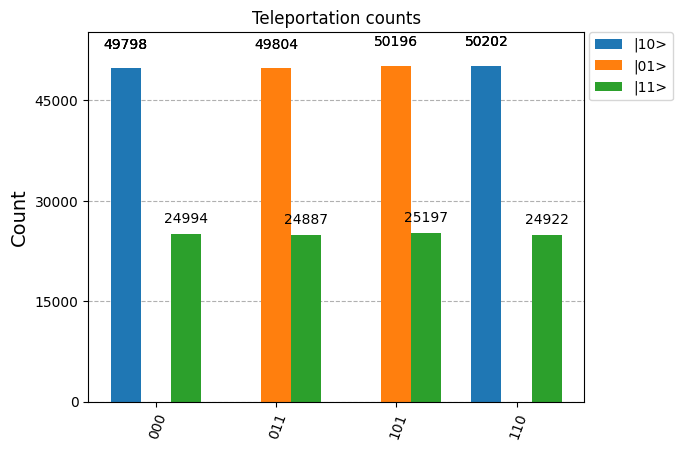

In [18]:
# measure some possible states
initial_states = [[1, 0], [0, 1], np.array([1, 1]) / 2**0.5]
states = []
counts = []

for state in initial_states:
    qc = quantum_teleportation(state)
    sim = AerSimulator(method='statevector')
    result = sim.run(qc, shots=100000).result()
    states.append(result.data()['initial state'])
    counts.append(result.get_counts())

plot_histogram(counts, title='Teleportation counts', legend=['|10>', '|01>', '|11>'])